In [1]:
#https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)

In [9]:
X.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [11]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [13]:
y.unique()

[class_0, class_1, class_2]
Categories (3, object): [class_0, class_1, class_2]

In [15]:
df = X.join(pd.Series(y, name='class'))

### LDA from scractch

In [16]:
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


In [23]:
within_class_scatter_matrix = np.zeros((13,13))

for c, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((13,13))

    for index, row in rows.iterrows():
        x, mc = row.values.reshape(13,1),class_feature_means[c].values.reshape(13,1)
        s += (x - mc).dot((x - mc).T)
    within_class_scatter_matrix += s

In [24]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((13,13))
for c in class_feature_means:    
    n = len(df.loc[df['class'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(13,1), feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [25]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [26]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

9.081739435042472
4.128469045639484
8.881784197001252e-16
7.41949604398113e-16
7.41949604398113e-16
6.57104310784389e-16
6.57104310784389e-16
2.9039090283069212e-16
2.9039090283069212e-16
2.58525572226227e-16
6.126103277916086e-17
6.126103277916086e-17
4.86945776983596e-17


In [27]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))


Explained Variance
Eigenvector 0: 0.6874788878860784
Eigenvector 1: 0.31252111211392164
Eigenvector 2: 6.723424698398662e-17
Eigenvector 3: 5.616486715430028e-17
Eigenvector 4: 5.616486715430028e-17
Eigenvector 5: 4.9742160522698054e-17
Eigenvector 6: 4.9742160522698054e-17
Eigenvector 7: 2.1982310366664338e-17
Eigenvector 8: 2.1982310366664338e-17
Eigenvector 9: 1.957013567229342e-17
Eigenvector 10: 4.637400906181487e-18
Eigenvector 11: 4.637400906181487e-18
Eigenvector 12: 3.686132415666904e-18


In [28]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real

In [29]:
X_lda = np.array(X.dot(w_matrix))

In [30]:
le = LabelEncoder()
y = le.fit_transform(df['class'])

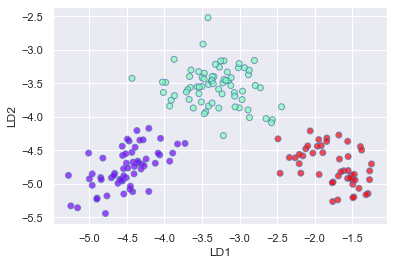

In [31]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

### LDA OutOfTheBox

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [34]:
lda.explained_variance_ratio_

array([0.6875, 0.3125])

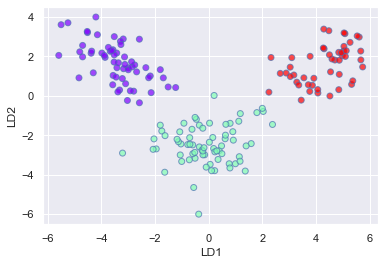

In [35]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)


### LDA vs PCA

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)

In [38]:
pca.explained_variance_ratio_

array([0.9981, 0.0017])

In [39]:
lda.explained_variance_ratio_

array([0.6875, 0.3125])

In [40]:
print(f"PCA explains {sum(pca.explained_variance_ratio_)} variance")
print(f"LDA explains {sum(lda.explained_variance_ratio_)} variance")

PCA explains 0.9998271461166032 variance
LDA explains 1.0 variance


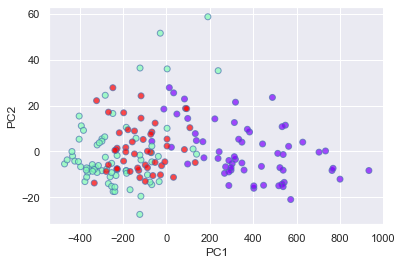

In [41]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state=1)

In [43]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[18,  0,  0],
       [ 0, 17,  0],
       [ 0,  0, 10]], dtype=int64)

In [2]:
import numpy as np

In [3]:
a = np.random.randn(4, 3) # a.shape = (4, 3)
b = np.random.randn(3, 2) # b.shape = (3, 2)
c = a*b

ValueError: operands could not be broadcast together with shapes (4,3) (3,2) 